# Introduction to Text Classification with Keras and Tensorflow

## Douglas Rice

*This tutorial was originally created by Burt Monroe and Sam Bestvater for their prior work with the Essex Summer School. I've updated and modified it.*

In this notebook, we'll develop our first neural network model. By the end of the notebook, you should be familiar with:


1. Set up a feed-forward neural network.
2. Evaluate a feed-forward neural network.
3. Update and modify a feed-forward neural network.



## Tensorflow

We'll be using Tensorflow [here](https://www.tensorflow.org/) and Keras [here](https://keras.io/) for building neural network models. Tensorflow is free and open-source (obviously) now, but it was initially developed internally by the folks at Google for their own neural network / AI development tasks. It was released publicly in 2015. Keras is the API built on top of TensorFlow; the idea is to make it "simpler" to build, evaluate, and compare complex neural networks. 

In [ ]:
!pip install tensorflow==2.5.0
!pip install -U tensorflow-text==2.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 454.3 MB 16 kB/s 
     |████████████████████████████████| 4.0 MB 56.5 MB/s 
     |████████████████████████████████| 14.8 MB 30.9 MB/s 
     |████████████████████████████████| 462 kB 66.0 MB/s 
     |████████████████████████████████| 132 kB 56.6 MB/s 
     |████████████████████████████████| 1.2 MB 57.0 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68717 sha256=9af1c9be34a245a2cdb642a29a748f73ec764cc1a70206bdbc1534908f357122
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: n

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 27.7 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6429402905991124969, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14474280960
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4998823727391232502
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 200

## Text Classification with a Deep Feedforward Network

### Load the IMDB data

We'll work with the IMDB review dataset that comes with keras. We're interested in the actual text (rather than just the representation of the text), so we need to do some work to map words to the indices. That ensures we'll be able to look at the text/effects later on with more meaningful insights than "word indexed 501 is associated with much more positive reviews!" 

The indices, except for 0 which corresponds to UNK_, start with "the" and get less frequent as the index increases. So we know the first 5000 words are the most frequent.


In [ ]:
# Retrieve the training sequences.
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=5000)
# Retrieve the word index file mapping words to indices
word_index = keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
inverted_word_index = dict((i, word) for (word, i) in word_index.items())
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in train_data[0])

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specif

1646592/1641221 [==============================] - 0s 0us/step


Now, we need to convert the IMDB dataset into something that's well-tailored for our application. Notice that we have lots of objects in the environment right now now: 


*   `train_data`: our data for training the model, stored as an array where each document is represented by a sequence of numbers that correspond to the indices. 
*   `test_data`: our data for testing the model, stored as an array where each document is represented by a sequence of numbers that correspond to the indices.
* `train_labels`: the labels (i.e. what we are predicting) for training our model, stored as an array.
* `test_labels`: the labels for testing our model, stored as an array.

We need to convert these to more usable formats for training and more particularly for *evaluating* the model. Therefore, we define a function (`vectorize_sequences`) that creates, for each row (i.e., document), a vector of length 5000 (or the number of words) where each entry indicates if a word was present in that document or not. We apply that function to the training and test dataframes, yielding `x_train` and `x_test`. We call these new matrices "multihot" representations for each document; they are a document-presence matrix of 1s and 0s.

In [ ]:
def vectorize_sequences(sequences, dimension = 5000):
    results = np.zeros((len(sequences), dimension))     # Creates an all-zero matrix of shape (len(sequences), dimension)
    for i, sequences in enumerate(sequences):
        results[i, sequences] = 1.                      # Sets specific indices of results[i] to 1s
    return results

# Vectorize test and training data
x_train = vectorize_sequences(train_data)               
x_test = vectorize_sequences(test_data)                 


The train and test labels are already stored in a format that is closer to what we want (i.e., we don't need to go about dealing with the indexing). 

In [ ]:
# Vectorize text and training labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')


Finally, when we train the neural network, the model evaluates as it goes. That means we should identify a "validation" set from our training set; this way, the neural network will be evaluated twice. First with this held-out, validation set in training, and second by an "invisible" test set that we retain for the final stage. Here, we'll pull aside 10,000 of our training documents (overkill probably) to use as validation data during the training phase.

In [ ]:
# Generate a validation set
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## Define the model architecture.

With all of that prep out of the way, we can finally turn to specifying a model. To do so, we need to specify a model architecture. We are starting with a basic use case, the feedforward network. A feedforward neural network can be built from simple layer building blocks from Keras using `models.Sequential`. 

We're building a "deep" model, so we define three keras layers. For all of them, we use "dense" layers, meaning every node in each layer is connected to every node in the next. For the first layer -- the layer that takes the inputs -- we need to specify the "input shape", which in this case is a one-dimensional vector of length 5000. We'll make each of our hidden layers consist of 16 nodes, with "relu" activation functions. (ReLU is short for **Re**ctified **L**inear **U**nit, and is generally taken to be the best default activation function for hidden layers.) Our output layer will consist of a single node, with a sigmoid (logistic) activation function outputting a probability of being positive.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [ ]:
# Determine model architecture
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape=(5000,)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation= 'sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                80016     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 80,305
Trainable params: 80,305
Non-trainable params: 0
_________________________________________________________________



The summary describes the structure we've set up. The number of parameters reflects the number of connections we are drawing (5,000 to 16 = 8,000; 16 to 16 = 256, 16 to 1 = 16). Note that at each stage, there are 16 extra parameters than there are nodes. This is because of bias parameters for each node, which effectively equates to one extra "always on" input.

## Compile and Fit your model - Optimizer, Loss, Metrics

The next step to compiling our model is specifying additional information about estimation now that we have the structure. These are our loss function, what optimizer we wish to use, and what metrics we want to keep track of. The "adam" optimizer is generally taken to be the default, but you might wish to try others. We'll use a binary cross-entropy loss function, which is exactly the same as the logit loss function from GLMs. We also tell it what performance metrics to track.


In [ ]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=50,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Epoch 1/50
30/30 [==============================] - 1s 16ms/step - loss: 0.5837 - accuracy: 0.7437 - val_loss: 0.4418 - val_accuracy: 0.8478
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.3503 - accuracy: 0.8800 - val_loss: 0.3218 - val_accuracy: 0.8757
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.2550 - accuracy: 0.9102 - val_loss: 0.2889 - val_accuracy: 0.8851
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.2067 - accuracy: 0.9273 - val_loss: 0.2860 - val_accuracy: 0.8830
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.1764 - accuracy: 0.9396 - val_loss: 0.2939 - val_accuracy: 0.8821
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.1538 - accuracy: 0.9487 - val_loss: 0.3053 - val_accuracy: 0.8791
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.1389 - accuracy: 0.9520 - val_loss: 0.3218 - val_accuracy: 0.8752
Epoch 8/50
30

Accuracy of 100% on the training data! Loss of zero! What does that mean?

In [ ]:
# .fit() returns a history object which is a dictionary containing data about everything that happened during training

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the loss and accuracy metrics from training for both the training and validation sets. 

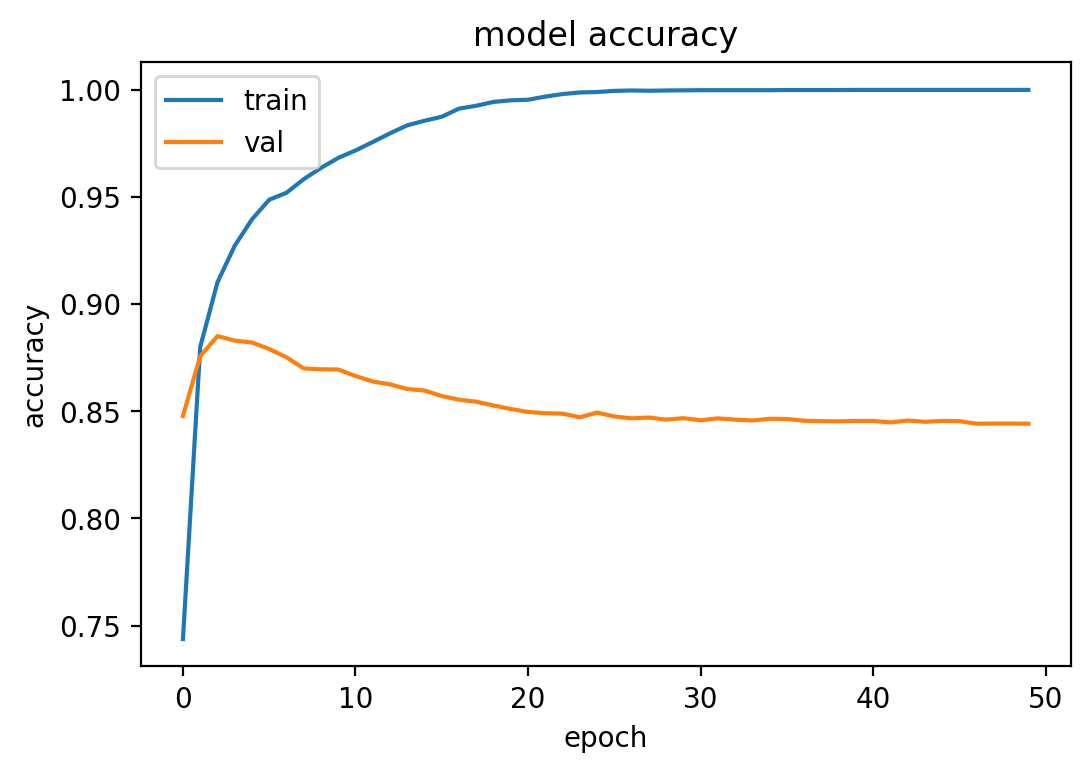

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

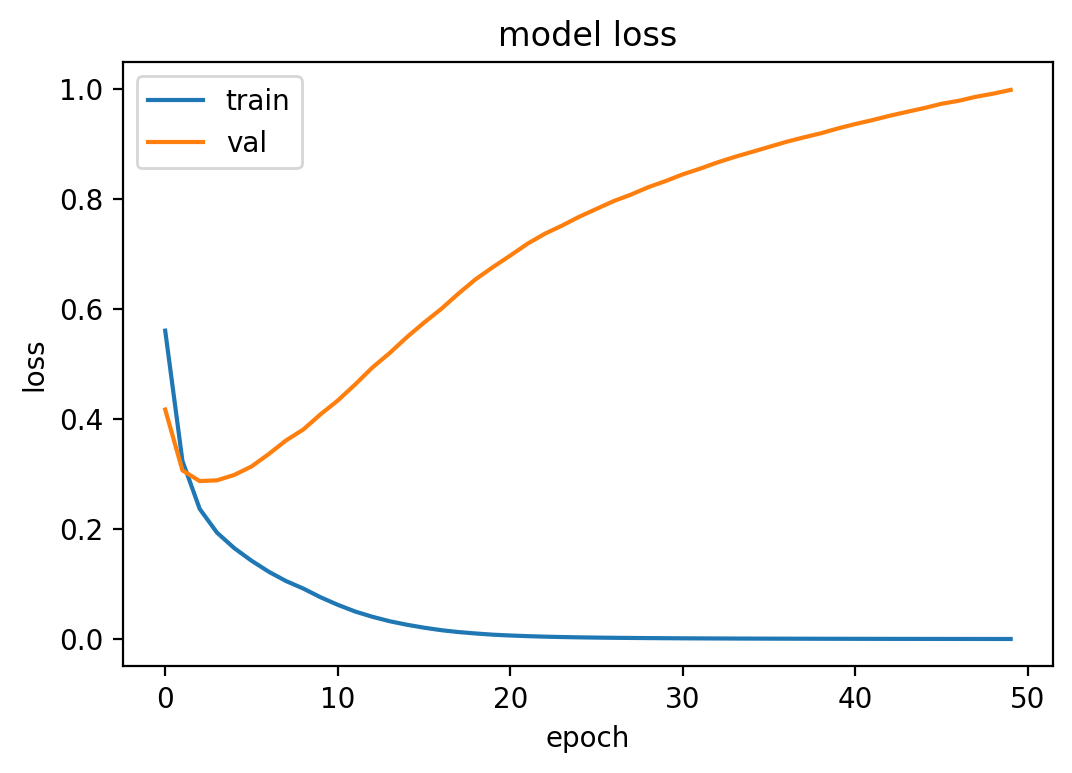

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Address overfitting

Overfitting. It basically memorized the training data. There are a number of things we can do, including regularizing weights and dropout, which we'll discuss later. For now, we can (manually) do "early stopping" by restarting and fitting at a smaller number of epochs. On different runs, the loss is minimized at 4 or 5 epochs.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape=(5000,)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=4,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Epoch 1/4
30/30 [==============================] - 1s 22ms/step - loss: 0.5499 - accuracy: 0.7669 - val_loss: 0.3932 - val_accuracy: 0.8536
Epoch 2/4
30/30 [==============================] - 0s 13ms/step - loss: 0.3044 - accuracy: 0.8920 - val_loss: 0.3110 - val_accuracy: 0.8744
Epoch 3/4
30/30 [==============================] - 0s 13ms/step - loss: 0.2269 - accuracy: 0.9194 - val_loss: 0.2877 - val_accuracy: 0.8824
Epoch 4/4
30/30 [==============================] - 0s 11ms/step - loss: 0.1859 - accuracy: 0.9361 - val_loss: 0.2910 - val_accuracy: 0.8816


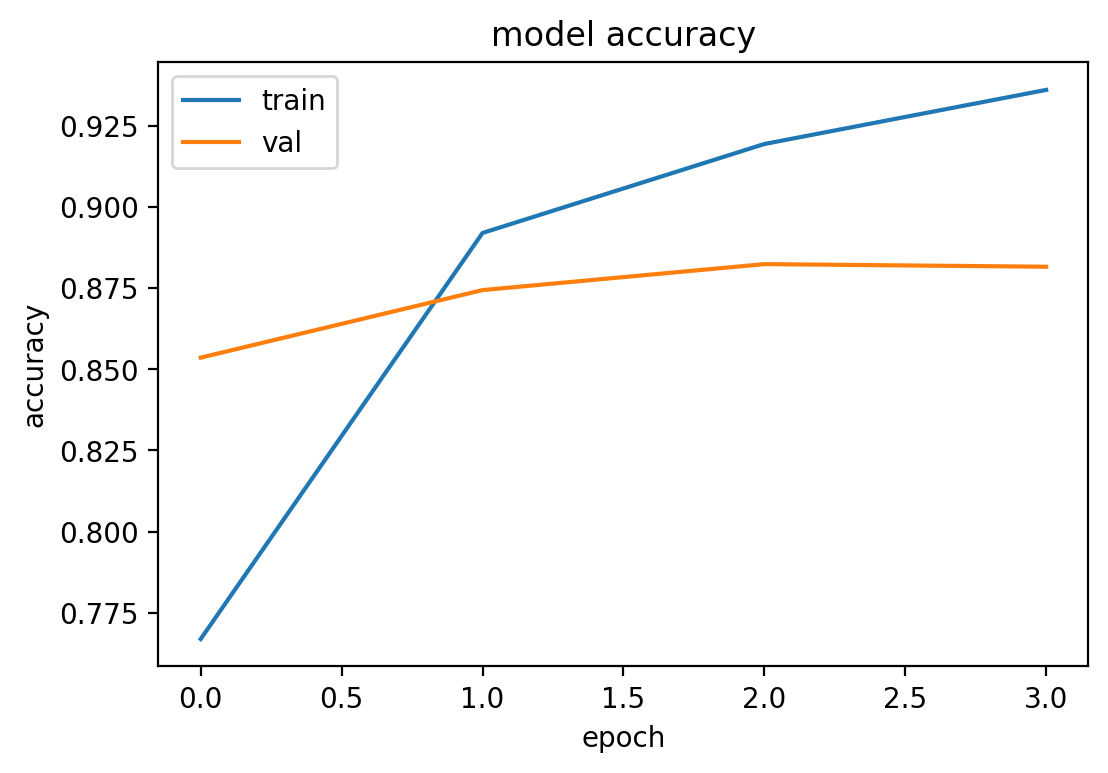

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

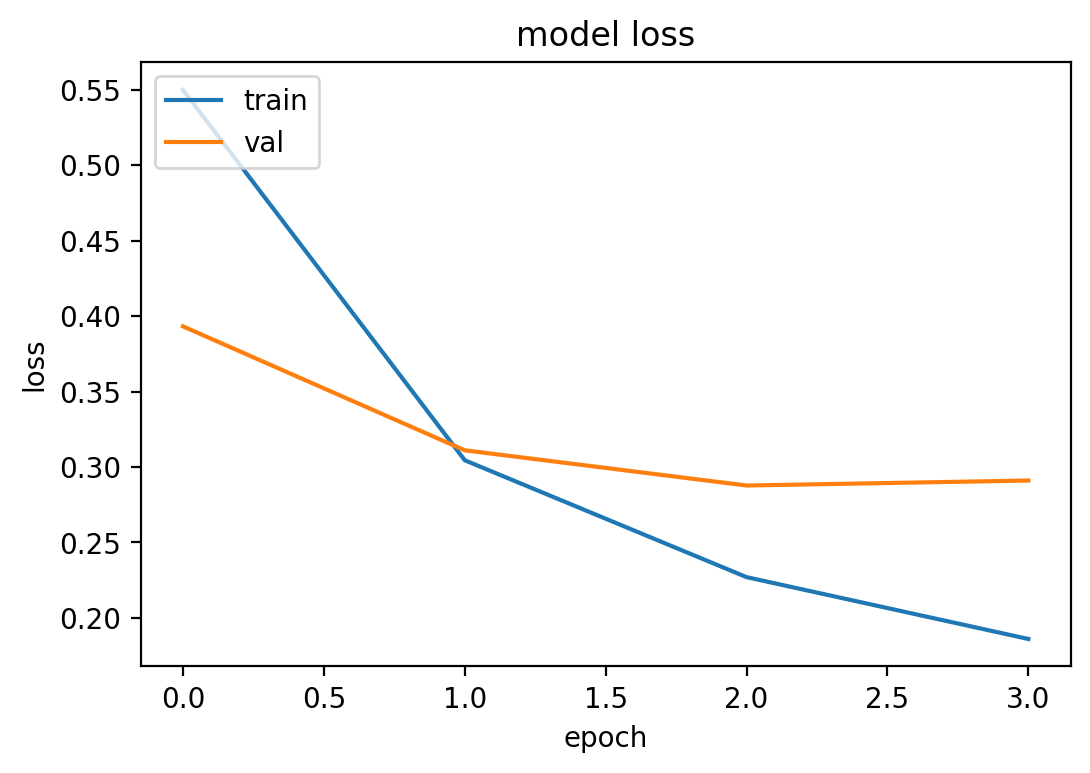

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluate with Out-of-Sample Data

Alright, the early stopping seems to have alleviated the overfitting. We can turn, then, to evaluating our model on the out-of-sample data that we put aside for testing earlier. To do so, we pass the `x_text` and `y_test` objects to our model.

In [ ]:
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.3036 - accuracy: 0.8760


[0.30358704924583435, 0.8759999871253967]

In the test data, we get accuracy of about 87.5% (it varies a bit with the stochastic element here). 

## Interpret

So, what happened there? What is the model learning? It learned a function that converts 5000 inputs into 16 hidden / latent / intermediate numbers, then converts those 16 into a different 16 intermediate numbers, and then those into 1 number at the output. Those intermediate functions are nonlinear, otherwise there wouldn't be any gain from stacking them together. But we can get an approximate idea of how these inputs map to the single output by treating each layer as linear and multiplying the weights through: $W^{(5000\times 1)}_{io} \approx W_{i1}^{(5000\times 16)} \times W_{12}^{(16\times 16)} \times W_{2o}^{(16\times 1)}$. Those aggregate weights can give us an approximate idea of the main marginal effect of each input. (This ignores the bias weights at each layer, and the rectified/zeroed out part of the relu activation functions. This will not work, generally speaking, in more complex models or contexts.)


In [ ]:
netweights = np.matmul(np.matmul(model.get_weights()[0],model.get_weights()[2]),model.get_weights()[4])
netweights.shape

(5000, 1)

In [ ]:
#featurelist = sorted(inverted_word_index.items(), key=lambda x: x[1], reverse=True)
featuretuplelist = sorted(inverted_word_index.items())
featurelist=[featuretuplelist[i][1] for i in range(len(featuretuplelist))]

In [ ]:
featurelist[0:10]

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i']

In [ ]:
word_index['the']

1

For reasons that elude me, the indexes are off not just by the extra UNK_ token but three more as well. So the odd indexing and padding below is to make things line up.

In [ ]:
coef_df=pd.DataFrame(netweights[1:3000,0],['UNK','UNK','UNK']+featurelist[0:2996],columns=["coef"])
coef_df['freq']=x_train.sum(axis=0)[1:3000].tolist()
coef_df.sort_values(by='coef', ascending=False)

,coef,freq
7,0.975069,832.0
8,0.831614,810.0
wonderfully,0.769113,312.0
excellent,0.767947,1777.0
rare,0.737045,413.0
...,...,...
boring,-0.768705,1506.0
awful,-0.814434,1442.0
waste,-0.840587,1303.0
disappointment,-0.865960,388.0


In [ ]:
coef_df.sort_values(by='coef',ascending=False).head(25)

,coef,freq
7,0.975069,832.0
8,0.831614,810.0
wonderfully,0.769113,312.0
excellent,0.767947,1777.0
rare,0.737045,413.0
funniest,0.695921,330.0
loved,0.695454,1246.0
wonderful,0.686863,1439.0
gem,0.666671,340.0
9,0.659190,675.0


In [ ]:
coef_df.sort_values(by='coef',ascending=True).head(25)

,coef,freq
worst,-0.884727,2265.0
disappointment,-0.865960,388.0
waste,-0.840587,1303.0
awful,-0.814434,1442.0
boring,-0.768705,1506.0
endless,-0.738006,222.0
disappointing,-0.722454,394.0
unfunny,-0.719117,232.0
pointless,-0.710992,460.0
lousy,-0.708690,202.0



"7" is interesting. It comes from reviews like #168, which ends with something like "7 out of 10 stars"

That means the entire ecosystem of imdb-data-sentiment-classifiers (thousands of examples) are solving a much easier problem than it superficially appears to be. Some of the reviews end with the text summarizing the rating with a number out of 10! And then use that to "predict" whether the review is positive or negative (which has been labeled based on the 10 point scale rating in the first place).

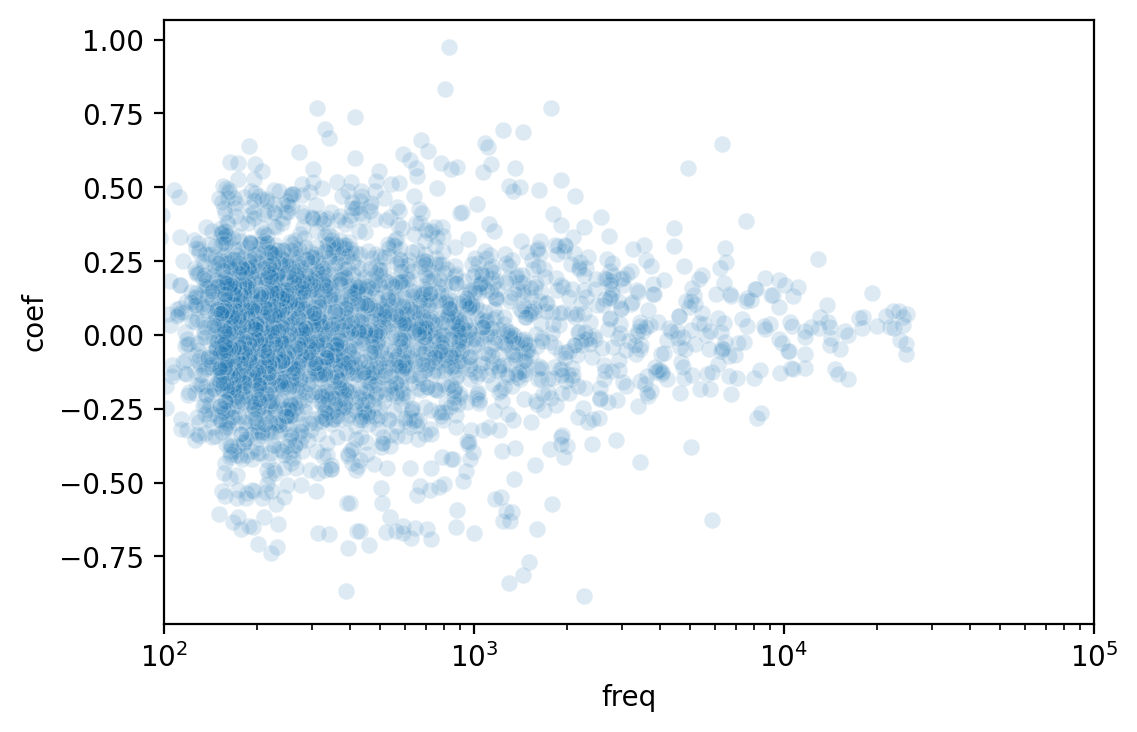

In [ ]:
import seaborn as sns
coefplot = sns.scatterplot(data = coef_df, x = "freq", y = "coef", alpha = .15)
coefplot.set(xscale="log")
coefplot.set(xlim=[100,100000])
plt.show(coefplot)

## Compare to perceptron / shallow model

It's worth pointing out that "deep" didn't buy us much of anything. If we just estimate with a single sigmoid (logistic) layer, we get nearly identical results that are very close.




So, we successfully built a deep feedforward network for text classification, but it showed only minimal improvement over a simpler model. In subsequent notebooks, we'll see if we can improve through other changes including dropout and regularization of weights.

## Practice Exercise: 

1. See if you can improve performance through changes in the architecture (number of layers, number of nodes, activation functions - https://keras.io/api/layers/activations/) or training options (optimizer - see https://keras.io/api/optimizers/, or loss function - https://keras.io/api/losses/)

2. Why is the current model overfitting?